In [1]:
#check nlspmc ndimo, ndimd
#NUCLEAR ZEEMAN IS 0!!!
#words of caution: we are dealing with very big matrices here, so memory allocation must be parsimonious
#no dense matrices!!!! Also, it seems adding an (n,1) and an (n,) matrix requires the generation of a (n,n) matrix. Here n~100000!
#usual caution: Python is oop, so use b = a.deepcopy() rather than b = a
from __future__ import division
import subprocess
import numpy as np
import math
from scipy.sparse import coo_matrix , csr_matrix, eye
from scipy.sparse.linalg import gmres, expm_multiply, LinearOperator, norm, bicgstab, spsolve
from scipy.sparse import kron as spkron
from scipy.sparse import identity as spiden
from stvec_gen import stvec_gen
#from pymatsolver import Pardiso
from scipy import io
import scipy
from DiffusionSuperoperator import DiffTensorNoPotential
import time
from common_defs import *
from indices import indgen
import os,sys
from expokit import *
from convert_mat import conv2coo
from propagator import PulsePropPlus1ToPlus2, PulsePropPlus2ToMinus1, PulsePropPlus2ToPlus1, PulsePropPlus1ToMinus1
#from pymatsolver import Pardiso

In [2]:
#R = [5.0e4, 5.0e4, 1.0e5] 
R = [5.0e8, 5.0e8, 1.0e9]
#R = [5.0e5, 5.0e5, 1.0e6]
g = [2.0087, 2.0057, 2.0021] #g factors
A = [6, 6, 36] #Gauss
B0 = 34050 #3300 #Gauss
g0 = 2.0021 #free e g factor

#diffusion tilt (all angles in degrees)
ald = 0#-5 
bed = 0#10
gad = 0#15

#magnetic tilt
alm = 0#-20
bem = 0#25
gam = 0#-30

#dipolar tilt !!!NEW!!!
aldip = 0#-20
bedip = 0#25
gadip = 0#-30

#director tilt
psi = 0.00001 #please don't make this 0, otherwise the reshaping logic will break down

#nuclear spin
In = 1 #nitroxide ideally
I2 = 2 * In
numI = (2*In+1)**2 #number of possible pI,qI pairs, will come into play while reshaping
ipnmx = 2 

#high field approx must be valid
if (B0 < 10 * max( max(A), (max(g)-min(g))*B0/g0) ):
    raise "High field approximation violated it seems"

#dipolar constant
D = 0 #need to change!!!!

#generate the matrix indices, diag and off-diag spaces   
print("\n")


In [9]:
ndimo, ndimd, ndimDipPlus1, ndimDipPlus2, ndimDipMinus1, ind_offdiag, ind_diag, ind_Plus1, ind_Plus2, ind_Minus1, \
Lstarts_offdiag, Lstarts_diag, Lstarts_Plus1, Lstarts_Plus2, Lstarts_Minus1, Llist = \
indgen(8, 7, 4, 3, 2, g, A, I2, [ald,bed,gad], [alm,bem,gam], [aldip, bedip, gadip], psi) #(75, 51, 25, 2, 2) 
#(30, 21, 15, 10, 2) #(8, 7, 4, 3, 2) #(25, 17, 13, 7,2)
print(Llist)
print(Lstarts_diag)
numL=len(Llist)
#stv = stvec_gen(ind_Plus1)
np.savetxt('ind_offdiag.txt',ind_offdiag,fmt='%d',delimiter=',')
np.savetxt('ind_diag.txt',ind_diag,fmt='%d',delimiter=',')
#np.savetxt('stv.txt',stv)
np.savetxt('ind_Plus1.txt', ind_Plus1, fmt='%d',delimiter=',')
np.savetxt('ind_Plus2.txt', ind_Plus2, fmt='%d',delimiter=',')
np.savetxt('ind_Minus1.txt', ind_Minus1 ,fmt='%d',delimiter=',')
np.savetxt('Llist.txt',Llist,fmt='%d')
np.savetxt('Lstarts_offdiag.txt',Lstarts_offdiag,fmt='%d')
np.savetxt('Lstarts_diag.txt',Lstarts_diag,fmt='%d')
np.savetxt('Lstarts_Plus1.txt',Lstarts_Plus1,fmt='%d',delimiter=',')
np.savetxt('Lstarts_Plus2.txt',Lstarts_Plus2,fmt='%d',delimiter=',')
np.savetxt('Lstarts_Minus1.txt',Lstarts_Minus1,fmt='%d',delimiter=',')
subprocess.run('gcc -o gen_mat -Wall -std=c11 -pg misc_fun.c wigner3j.c wigner_matrices.c A_functions.c R_functions.c gen_mat.c normalization.c -lm', check=True)
print('Executing .\gen_mat.exe '+str(B0)+' '+str(psi)+' '+str(In)+' '+str(g[0])+' '+str(g[1])+' '+str(g[2])+' '+str(A[0])+' '+str(A[1])+\
          ' '+str(A[2])+' '+str(R[0])+' '+str(R[1])+' '+str(R[2])+' '+str(ald)+' '+str(bed)+' '+str(gad)+' '+str(alm)+\
           ' '+str(bem)+' '+str(gam)+' '+str(aldip)+' '+str(bedip)+' '+str(gadip)+' '+str(D)+' '+str(ndimo)+' '+str(ndimd)+\
           ' '+str(ndimDipPlus1)+' '+str(ndimDipPlus2)+' '+str(ndimDipMinus1)+' '+str(numL))
os.system('.\gen_mat.exe '+str(B0)+' '+str(psi)+' '+str(In)+' '+str(g[0])+' '+str(g[1])+' '+str(g[2])+' '+str(A[0])+' '+str(A[1])+\
          ' '+str(A[2])+' '+str(R[0])+' '+str(R[1])+' '+str(R[2])+' '+str(ald)+' '+str(bed)+' '+str(gad)+' '+str(alm)+\
           ' '+str(bem)+' '+str(gam)+' '+str(aldip)+' '+str(bedip)+' '+str(gadip)+' '+str(D)+' '+str(ndimo)+' '+str(ndimd)+\
           ' '+str(ndimDipPlus1)+' '+str(ndimDipPlus2)+' '+str(ndimDipMinus1)+' '+str(numL))
stt = time.time()

#off-diagonal space matrix
matxi = conv2coo('matxi.txt',ndimo) #B0 * iden already subtracted
matxr = DiffTensorNoPotential(ind_offdiag, R, g)
matx = matxr + 1.0j * matxi

#diagonal space matrix
matzi = conv2coo('matzi.txt',ndimd)
matzr = DiffTensorNoPotential(ind_diag, R, g)
matz = matzr + 1.0j * matzi

#dipolar matrix
#matdip_Plus1 = 1.0j * conv2coo('matdip_Plus1.txt',ndimDipPlus1)
#matdip_Minus1 = 1.0j * conv2coo('matdip_Minus1.txt',ndimDipPlus1)

#convert all matrices to CSR
matx = matx.tocsr()
matz = matz.tocsr()
#matdip_Plus1 = matdip_Plus1.tocsr()
#matdip_Minus1 = matdip_Minus1.tocsr()
#define maty, pS=-1 matrix
maty = matx.conjugate()

grand_size = ndimDipPlus1*numI**2

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 18, 18, 198, 324, 702, 954, 1332, 1584, 1962]
Executing .\gen_mat.exe 34050 1e-05 1 2.0087 2.0057 2.0021 6 6 36 500000000.0 500000000.0 1000000000.0 0 0 0 0 0 0 0 0 0 0 981 1962 436 109 436 9


In [8]:
a = np.loadtxt('de_matlab_realh_34050_9.mtxx', delimiter=',')

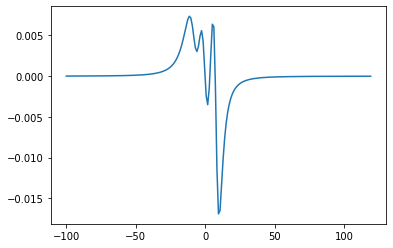

In [14]:
#calculate CW spectrum to check if it makes sense, actually there needs to be a perfect match
stvx = np.zeros(matx.shape[0])
stvx[0] = stvx[1] = stvx[2] = 1/math.sqrt(3)
shiftr = 0.5
results = []
omarr = np.linspace(-100,120,200)
for om in omarr:
    x = spsolve(matx+(shiftr-1.0j*om)*spiden(matx.shape[0]), stvx)
    results.append(np.real(x.dot(stvx)))

import matplotlib.pyplot as plt
plt.plot(omarr[:-1],np.diff(results))

In [ ]:
#off-diagonal space matrix
matxi = conv2coo('matxi.txt',ndimo) #B0 * iden already subtracted
matxr = DiffTensorNoPotential(ind_offdiag, R, g)
matx = matxr + 1.0j * matxi

#diagonal space matrix
matzi = conv2coo('matzi.txt',ndimd)
matzr = DiffTensorNoPotential(ind_diag, R, g)
matz = matzr + 1.0j * matzi


In [6]:
#starting vector
#stv = np.reshape(stv,(-1,numI,numI,4)).astype(complex) #astype(complex) unnecessary, remove it
nuc_stv = np.zeros(numI)
for i in range(2*In+1):
    nuc_stv[i] = 1.0/math.sqrt(2*In+1)
tmp = np.kron(np.kron(nuc_stv, nuc_stv),np.ones(4))
stvPlus1 = np.concatenate((tmp,np.zeros(grand_size-tmp.shape[0]))).reshape(-1,1)

In [7]:
#forget Ilya trick, just create matrices and prune

matrixPlus1t = spkron(matx, spiden(7))
matrixPlus1t.shape

(25137, 25137)

In [8]:
def matvec_Plus1(v):
    #print(v.shape, ndimDipPlus1,ndimDipPlus2,ndimo,ndimd)
    v = np.reshape(v,(-1,numI,numI,4))
    #v expected to be in the pS1+pS2 = 1 coherence subspace 
    #reshape to a 4 dimensional array: <L,jK,K,M>  <pIa,qIa>  <pIb,qIb>  <pSa,pSb,qSa,qSb>
    #                                     ?        (2I+1)**2  (2I+1)**2   4(for pS_tot=1)
    #x,y: case variables; within x/y you split into a/b and then sum the a and b components, followed by a concat to rejoin x,y
    v_x = v[:,:,:,:2] #cases where electron a in off-diag space, electron b in diag space
    v_y = v[:,:,:,2:] #cases where electron b in off-diag space, electron a in diag space
    #act on v_x, act on v_y, then stitch v_x, v_y back together
    #v_x: propagate the off-diag space for electron a, diag space for electron b, add the 2 results
    #off-diag space electron a
    v_xa = np.transpose(v_x,(0,1,3,2))
    v_xa = np.reshape(v_xa,(-1,2*numI))
    v_xa = matx@v_xa
    v_xa = np.reshape(v_xa,(-1,numI,2,numI)) 
    v_xa = np.transpose(v_xa,(0,1,3,2)) #back to the original form
    #diag space electron b
    v_xb = np.transpose(v_x,(0,2,3,1))
    v_xb = np.reshape(v_xb,(-1,numI))
    v_xb = matz@v_xb
    v_xb = np.reshape(v_xb,(-1,numI,2,numI)) 
    v_xb = np.transpose(v_xb,(0,3,1,2)) #back to the original 4d form

    #v_y: propagate the off-diag space for electron b, diag space for electron a, add the 2 results
    #diag space electron a
    v_ya = np.transpose(v_y,(0,1,3,2))
    v_ya = np.reshape(v_ya,(-1,numI))
    v_ya = matz@v_ya
    v_ya = np.reshape(v_ya,(-1,numI,2,numI)) 
    v_ya = np.transpose(v_ya,(0,1,3,2)) #back to the original 4d form
    #off-diag space electron b
    v_yb = np.transpose(v_y,(0,2,3,1))
    v_yb = np.reshape(v_yb,(-1,2*numI))
    v_yb = matx@v_yb
    v_yb = np.reshape(v_yb,(-1,numI,2,numI))
    v_yb = np.transpose(v_yb,(0,3,1,2)) #back to the original 4d form
    #dipolar
    vdip = np.transpose(v,(0,3,1,2))
    vdip = np.reshape(vdip,(-1,numI**2))
    vdip = matdip_Plus1@vdip
    vdip = np.reshape(vdip,(-1,4,numI,numI))
    vdip = np.transpose(vdip,(0,2,3,1)) #back to the original 4d form
    ans = np.concatenate((v_xa+v_xb,v_ya+v_yb),axis=3) + vdip
    return np.reshape(ans,(-1,1))

def matvec_Minus1(v):
    v = np.reshape(v,(-1,numI,numI,4))
    #v expected to be in the pS1+pS2 = -1 coherence subspace 
    #reshape to a 4 dimensional array: <L,jK,K,M>  <pIa,qIa>  <pIb,qIb>  <pSa,pSb,qSa,qSb>
    #                                     ?        (2I+1)**2  (2I+1)**2   4(for pS_tot=1)
    #x,y: case variables; within x/y you split into a/b and then sum the a and b components, followed by a concat to rejoin x,y
    v_x = v[:,:,:,:2] #cases where electron a in off-diag space, electron b in diag space
    v_y = v[:,:,:,2:] #cases where electron b in off-diag space, electron a in diag space
    #act on v_x, act on v_y, then stitch v_x, v_y back together
    #v_x: propagate the off-diag space for electron a, diag space for electron b, add the 2 results
    #off-diag space electron a
    v_xa = np.transpose(v_x,(0,1,3,2))
    v_xa = np.reshape(v_xa,(-1,2*numI))
    v_xa = maty@v_xa
    v_xa = np.reshape(v_xa,(-1,numI,2,numI)) 
    v_xa = np.transpose(v_xa,(0,1,3,2)) #back to the original 4d form
    #diag space electron b
    v_xb = np.transpose(v_x,(0,2,3,1))
    v_xb = np.reshape(v_xb,(-1,numI))
    v_xb = matz@v_xb
    v_xb = np.reshape(v_xb,(-1,numI,2,numI)) 
    v_xb = np.transpose(v_xb,(0,3,1,2)) #back to the original 4d form

    #v_y: propagate the off-diag space for electron b, diag space for electron a, add the 2 results
    #diag space electron a
    v_ya = np.transpose(v_y,(0,1,3,2))
    v_ya = np.reshape(v_ya,(-1,numI))
    v_ya = matz@v_ya
    v_ya = np.reshape(v_ya,(-1,numI,2,numI)) 
    v_ya = np.transpose(v_ya,(0,1,3,2)) #back to the original 4d form
    #off-diag space electron b
    v_yb = np.transpose(v_y,(0,2,3,1))
    v_yb = np.reshape(v_yb,(-1,2*numI))
    v_yb = maty@v_yb
    v_yb = np.reshape(v_yb,(-1,numI,2,numI))
    v_yb = np.transpose(v_yb,(0,3,1,2)) #back to the original 4d form
    #dipolar
    vdip = np.transpose(v,(0,3,1,2))
    vdip = np.reshape(vdip,(-1,numI**2))
    vdip = matdip_Plus1@vdip
    vdip = np.reshape(vdip,(-1,4,numI,numI))
    vdip = np.transpose(vdip,(0,2,3,1)) #back to the original 4d form
    ans = np.concatenate((v_xa+v_xb,v_ya+v_yb),axis=3) + vdip
    return np.reshape(ans,(-1,1))

def matvec_Plus2(v):
    #v = np.reshape(v,(-1,numI,numI,1))
    #v expected to be in the pS1+pS2 = 2 coherence subspace 
    #reshape to a 4 dimensional array: <L,jK,K,M>  <pIa,qIa>  <pIb,qIb>  <pSa,pSb,qSa,qSb>
    #                                     ?        (2I+1)**2  (2I+1)**2   1(for pS_tot=2)
    #act on v_a, act on v_b, then sum v_a, v_b
    #v_a: off-diag space electron a
    v = np.reshape(v,(-1,numI,numI,1))
    v_a = np.transpose(v,(0,1,3,2))
    v_a = np.reshape(v_a,(-1,numI))
    #print(v_a.shape,matx.shape)
    v_a = matx@v_a
    v_a = np.reshape(v_a,(-1,numI,1,numI)) 
    v_a = np.transpose(v_a,(0,1,3,2)) #back to the original 4d form
    #v_b: off-diag space electron bod solution to find a satisfactory house to rent? Is this problem that hard? There are so many players in this segment still there was no good solution. And this is not just my experience. A few of my friends also found their flats in the
    v_b = np.transpose(v,(0,2,3,1))
    v_b = np.reshape(v_b,(-1,numI))
    v_b = matx@v_b
    v_b = np.reshape(v_b,(-1,numI,1,numI))
    v_b = np.transpose(v_b,(0,3,1,2)) #back to the original 4d form
    #no dipolar term, +2 coherence has density matrix Sa+ Sb+, dipolar term 
    ans = v_a+v_b
    return np.reshape(ans,(-1,1))

def matvec_Minus2(v):
    #v = np.reshape(v,(-1,numI,numI,1))
    #v expected to be in the pS1+pS2 = 2 coherence subspace 
    #reshape to a 4 dimensional array: <L,jK,K,M>  <pIa,qIa>  <pIb,qIb>  <pSa,pSb,qSa,qSb>
    #                                     ?        (2I+1)**2  (2I+1)**2   1(for pS_tot=+-2)
    #act on v_a, act on v_b, then sum v_a, v_b
    #v_a: off-diag space electron a
    v = np.reshape(v,(-1,numI,numI,1))
    v_a = np.transpose(v,(0,1,3,2))
    v_a = np.reshape(v_a,(-1,numI))
    #print(v_a.shape,maty.shape)
    v_a = maty@v_a
    v_a = np.reshape(v_a,(-1,numI,1,numI)) 
    v_a = np.transpose(v_a,(0,1,3,2)) #back to the original 4d form
    #v_b: off-diag space electron b
    v_b = np.transpose(v,(0,2,3,1))
    v_b = np.reshape(v_b,(-1,numI))
    v_b = maty@v_b
    v_b = np.reshape(v_b,(-1,numI,1,numI))
    v_b = np.transpose(v_b,(0,3,1,2)) #back to the original 4d form
    #no dipolar term, +2 coherence has density matrix Sa+ Sb+, dipolar term 
    ans = v_a+v_b
    return np.reshape(ans,(-1,1))


In [9]:
cfact = 17
t1 = 0.200
t2 = 0.020

mat_Plus1 = LinearOperator((grand_size,grand_size),matvec=matvec_Plus1)
#anorm_Plus1 = norm(matx,np.inf) + norm(matz,np.inf) + norm(matdip_Plus1,np.inf)

mat_Minus1 = LinearOperator((grand_size,grand_size),matvec=matvec_Minus1)
#anorm_Minus1 = norm(maty,np.inf) + norm(matz,np.inf) + norm(matdip_Minus1,np.inf)

mat_Plus2 = LinearOperator((int(grand_size/4),int(grand_size/4)),matvec=matvec_Plus2)
#anorm_Plus2 = norm(matx,np.inf) * norm(matx,np.inf)

mat_Minus2 = LinearOperator((int(grand_size/4),int(grand_size/4)),matvec=matvec_Minus2)
#anorm_Minus2 = norm(maty,np.inf) * norm(maty,np.inf)

In [10]:
stt = time.time()
wxxx = mat_Plus1@np.ones_like(stvPlus1)
stp = time.time()
print("Time taken: {} seconds".format(stp-stt))

Time taken: 0.023935556411743164 seconds


In [13]:
stt = time.time()
w, err, hump = expv(-cfact * t1/200 ,mat_Plus1, stvPlus1, 0.00000001)
stp = time.time()
print("Time taken: {} seconds".format(stp-stt))
stt = time.time()
#wbad, errbad, humpbad = expv1stepnew(-cfact * t1 ,mat_Plus1, stvPlus1, 0.00000001)
wbad = expv1step(-cfact * t1/200 ,mat_Plus1, stvPlus1, 0.00000001)
stp = time.time()
print("Time taken: {} seconds".format(stp-stt))

#tt = -cfact * t1 * mat1*stv
print('maxabs=',np.max(np.abs(wbad-w)))

A.shape[0] is 35316
1
Time taken: 1.959015130996704 seconds
Time taken: 1.0888473987579346 seconds
maxabs= 1.0007415106216802e-16


In [16]:
stvPlus2 = PulsePropPlus1ToPlus2(grand_size,int(grand_size/4),math.pi/2,0.0) @ w
stt = time.time()
w, err, hump = expv(-cfact * t2 ,mat_Plus2, stvPlus2, 0.00001) #anorm_Plus2)
stp = time.time()
print("Time taken: {} seconds".format(stp-stt))

print('maxabs=',np.max(np.abs(w)))

#stvMinus1 = PulsePropPlus2ToMinus1(int(grand_size/4),grand_size,math.pi/2,0.0) @ w
stvPlus1Again = PulsePropPlus2ToPlus1(int(grand_size/4),grand_size,math.pi/2,0.0) @ w

A.shape[0] is 8829
11
Time taken: 2.822450876235962 seconds
maxabs= 0.08145233812395922


In [30]:
lst = [0] #[np.dot(stvMinus1,stvPlus1)[0]]
dt3 = 0.010
NGRD = 50
#NGRD includes dt3*1,....,dt3*NGRD
wPlus1 = np.zeros((grand_size,(NGRD+1)),dtype=complex)
wPlus1[:,0] = np.reshape(stvPlus1,(-1,))
stt = time.time()
t3 = 0
for i in range(1,NGRD+1):
    wPlus1[:,i],_,_ = expv(-cfact * dt3/2, mat_Plus1, wPlus1[:,i-1], 0.0001) #anorm_Minus1)
    wPlus1[:,i] = PulsePropPlus1ToMinus1(grand_size,grand_size,math.pi/2,0.0) @ wPlus1[:,i]
    t3 += dt3
    w,_,_ = expv(-cfact * t3/2,mat_Minus1, w, 0.0001)
    lst.append(np.dot(w,stvPlus1)[0]) #stvPlus1 is actually stvMinus1
stp = time.time()
print('Time taken: {} seconds'.format(stp-stt))
print(lst)

np.savetxt('out6.txt',np.array(lst, dtype=complex))

A.shape[0] is 35316
14
A.shape[0] is 35316
13
A.shape[0] is 35316
18
A.shape[0] is 35316
25
A.shape[0] is 35316
29
A.shape[0] is 35316
35
A.shape[0] is 35316
40
A.shape[0] is 35316
46
A.shape[0] is 35316
51
A.shape[0] is 35316
57
A.shape[0] is 35316
62
A.shape[0] is 35316
67
A.shape[0] is 35316
70
A.shape[0] is 35316
74
A.shape[0] is 35316
80
A.shape[0] is 35316


C:\Users\DELL\Documents\GitHub\DoubleElectron\FastDoubleElectronKSymBasis\expokit.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  t_new = gamma * t_step * (t_step * tol / err_loc) ** xm


OverflowError: cannot convert float infinity to integer

In [ ]:
stv = stvMinus1
NGRD=128
shiftr=0.2 #Gauss
data=np.zeros((NGRD,2))
ci=(0+1j)
iden = LinearOperator((grand_size,grand_size),matvec=lambda x:x)
rnge=100 #Gauss
init_guess = 0*stv
op=mat_Minus1+shiftr*iden

stt = time.time()
x, info = gmres(op,stv,maxiter=50,x0=init_guess)
stp = time.time()
print("Time taken: {} seconds".format(stp-stt))

In [ ]:
stt = time.time()
maxiter = 300
x, info = gmres(op,stv,maxiter=maxiter)
stp = time.time()
print("Time taken: {} seconds, answer:{} ".format(stp-stt, np.vdot(stvPlus1,x)))
#R_{pll} = 1e9: 
#50 (0.03681219283082806+0.0012859105573041372j)  25 s
#100 (0.058755629632917715+0.001987286374930817j) 50 s
#200 (0.06983165877824854+0.0023140306187613303j)  100 s
#300 (0.07120657630758251+0.002342490073326554j) 150 s

In [ ]:
a = np.array([1,0j,1.0])
np.vdot(a,a)

In [20]:
dt3/2

0.005

cfact = 17
t1 = 0.200
t2 = 0.020

mat_Plus1 = LinearOperator((grand_size,grand_size),matvec=matvec_Plus1)
anorm_Plus1 = norm(matx,np.inf) + norm(matz,np.inf) + norm(matdip_Plus1,np.inf)

mat_Minus1 = LinearOperator((grand_size,grand_size),matvec=matvec_Minus1)
anorm_Minus1 = norm(maty,np.inf) + norm(matz,np.inf) + norm(matdip_Minus1,np.inf)

mat_Plus2 = LinearOperator((int(grand_size/4),int(grand_size/4)),matvec=matvec_Plus2)
anorm_Plus2 = norm(matx,np.inf) + norm(matz,np.inf)

w, err, hump = expv(-cfact * t1 ,mat_Plus1, stvPlus1, anorm_Plus1)
#tt = -cfact * t1 * mat1*stv
print('maxabs=',np.max(np.abs(w)))

stvPlus2 = PulsePropPlus1ToPlus2(grand_size,int(grand_size/4),math.pi/2,0.0) @ w
w, err, hump = expv(-cfact * t2 ,mat_Plus2, stvPlus2, anorm_Plus2)
print('maxabs=',np.max(np.abs(w)))

stvMinus1 = PulsePropPlus2ToMinus1(int(grand_size/4),grand_size,math.pi/2,0.0) @ w
w = stvMinus1

stv = w
NGRD=128
shiftr=0.2 #Gauss
data=np.zeros((NGRD,2))
ci=(0+1j)
iden = LinearOperator((grand_size,grand_size),matvec=lambda x:x)
rnge=100 #Gauss
init_guess = 0*stv
for j in range(NGRD):
    shift=np.complex(shiftr,-rnge+j*2*rnge/(NGRD-1)) #in Gauss
    op=mat_Minus1+shift*iden
    x, info = gmres(op,stv,maxiter=50,x0=init_guess)
    if info<0:
        print("No")
    init_guess = x
    #print('x.shape',x.shape)
    data[j][0]=-rnge+j*2*rnge/(NGRD-1)
    #print(np.vdot(stv,x).shape)
    data[j][1]=np.real(np.vdot(stvPlus1,x))
np.savetxt("out_spec.txt",data)

#lst = [np.dot(stvMinus1,stvPlus1)[0]]
#dt3 = 0.010
#for i in range(50):
    #w, err, hump = expv(-cfact * dt3,mat_Minus1, w, anorm_Minus1)
    #lst.append(np.dot(w,stvPlus1)[0]) #stvPlus1 is actually stvMinus1
#print(lst)
#np.savetxt('out6.txt',np.array(lst, dtype=complex))

#tt = matvec_Plus1(stv)
#print(tt.shape,stv.shape)
#print(np.max(np.abs(tt-3*stv)))

#time required to construct the full (re+im) SLE matrix
stp = time.time()
print(stp-stt, ' seconds')

#np.dot(stvx.T,np.matmul(matx,stvx))
#print(stvx.shape)
sys.exit()

NGRD=512
shiftr=0.2 #Gauss
data=np.zeros((NGRD,2))
ci=(0+1j)
rnge=100 #Gauss
for j in range(NGRD):
    shift=np.complex(shiftr,-rnge+j*2*rnge/(NGRD-1)) #in Gauss
    op=matx+shift*iden
    x, info = gmres(op,stvx)
    #print('x.shape',x.shape)
    data[j][0]=-rnge+j*2*rnge/(NGRD-1)
    #print(np.vdot(stvx,x).shape)
    data[j][1]=np.real(np.vdot(stvx,x))
np.savetxt("out_spec.txt",data)

In [9]:
from scipy.sparse import random
import numpy as np
import time 
N = 30000
A = random(N,N,0.005)
v = np.random.rand(N,1)

time taken: {} secs 0.02973341941833496


In [28]:
stt = time.time()
x = A @ v
stp = time.time()
print('time taken: {} secs'.format(stp-stt))

time taken: 0.02308034896850586 secs


In [26]:
v.shape
A.shape

(30000, 30000)

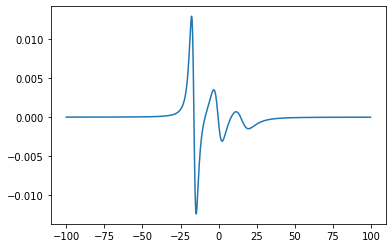

In [3]:
import matplotlib.pyplot as plt
import numpy as np
out_spec = np.loadtxt('../out_spec.txt')
plt.plot(out_spec[:-1,0], np.diff(out_spec[:,1]))

In [ ]:
from convert_mat import conv2coo
import math
from scipy.sparse.linalg import spsolve
from scipy.sparse import identity as spiden
matxide = conv2coo('de_matlab_imagh_34050_9.mtxx',84, delimiter=',') #B0 * iden already subtracted
matxrde = conv2coo('de_matlab_realh_34050_9.mtxx',84, delimiter=',')
matxde = matxrde + 1.0j * matxide
matx = matxde
#calculate CW spectrum to check if it makes sense, actually there needs to be a perfect match
stvx = np.zeros(matx.shape[0])
stvx[0] = stvx[1] = stvx[2] = 1/math.sqrt(3)
shiftr = 0.5
results = []
omarr = np.linspace(-100,120,200)
for om in omarr:
    x = spsolve(matx+(shiftr-1.0j*om)*spiden(matx.shape[0]), stvx)
    results.append(np.real(x.dot(stvx)))

import matplotlib.pyplot as plt

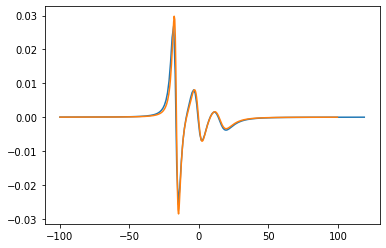

In [22]:
plt.plot(omarr[:-1],np.diff(results))
plt.plot(out_spec[:-1,0], np.diff(out_spec[:,1])*2.3)

In [17]:
out_spec[abs(out_spec[:,0]-1) < 5e-1, :]

array([[0.58708415, 0.07970352],
       [0.97847358, 0.07789282],
       [1.36986301, 0.07553342]])

In [18]:
tt = np.concatenate((omarr.reshape((-1,1)), np.array(results).reshape((-1,1))), axis=1)
tt[abs(tt[:,0]-1) < 8e-1, :]

array([[0.60301508, 0.07437082],
       [1.70854271, 0.06938648]])

In [15]:
tt[:5,:]

array([[-1.00000000e+02,  4.23326455e-04],
       [-9.88944724e+01,  4.34970416e-04],
       [-9.77889447e+01,  4.47045702e-04],
       [-9.66834171e+01,  4.59573135e-04],
       [-9.55778894e+01,  4.72574809e-04]])

In [25]:
a = 'sdfag'
list(a)

['s', 'd', 'f', 'a', 'g']